Exploring and creating graphs from the data gathered parsing the Price is Right Episode Guide webpages.  The Showcase showdown where the contestants spin the big wheel to try and advance to the final showcase was parsed.  The link below explains this part of the show.

https://priceisright.fandom.com/wiki/Showcase_Showdown

In [1]:
import os
import sys
import datetime
import numpy as np
import pickle
import pandas as pd
import datetime
import re
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Load the Data

In [2]:
df = pd.read_csv(r"FullContent.csv", parse_dates=['airDate'])
df.shape

(26791, 40)

In [3]:
# This limits to only pages that were successfully parsed and cleaned
sc_df = df.loc[~df.Total.isna()].copy()
# The data above but with only 1 row per showdown instead of a row per contestant
sc1r_df = pd.read_csv(r"OneRowData.csv", parse_dates=['airDate'])
sc_df.shape, sc1r_df.shape

((24864, 40), (8288, 57))

In [4]:
df.head(3)

,url,episodeID,errorCode,footer,urlParam,EpsCategory,airDate,SC_ind,PrizeValue,Contestant,...,SpinOff2,SpinOff2Max,SpinOff2Match,SpinOff2MatchCnt,SpinOff3,SpinOff3Max,SpinOff3Match,SpinOff3MatchCnt,Bonus,Winner
0,https://tpirepguide.com/?p=18052,9782K,0,"March 29th, 2022 | Category: Carey Eps",18052,Carey Eps,2022-03-29,1.0,"1,340",Maurice,...,NaN,NaN,False,0.0,NaN,NaN,False,0.0,NaN,False
1,https://tpirepguide.com/?p=18052,9782K,0,"March 29th, 2022 | Category: Carey Eps",18052,Carey Eps,2022-03-29,2.0,"8,531",Kim,...,NaN,NaN,False,0.0,NaN,NaN,False,0.0,50.0,True
2,https://tpirepguide.com/?p=18052,9782K,0,"March 29th, 2022 | Category: Carey Eps",18052,Carey Eps,2022-03-29,3.0,"25,760",Sandra,...,NaN,NaN,False,0.0,NaN,NaN,False,0.0,NaN,False


### Showdowns Captured
What percent of urls were successfully parsed by Year

In [5]:
year_sum = df.groupby(['urlParam', df.airDate.dt.year]).Contestant.count().reset_index()
year_sum['Found'] = (year_sum.Contestant > 0)
year_sum = year_sum.groupby(['airDate']).Found.agg(['count', 'sum']).reset_index()
year_sum = year_sum.rename(columns={'count': 'Episodes', 'sum': 'Captured'})
year_sum['RateFound'] = year_sum.Captured * 1.0 / year_sum.Episodes
year_sum.head(3)

,airDate,Episodes,Captured,RateFound
0,1972,84,0,0.0
1,1973,80,0,0.0
2,1974,30,0,0.0


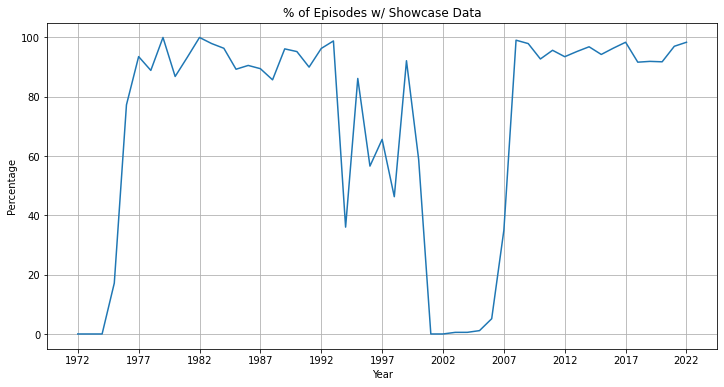

In [6]:
plt.figure(figsize=(12, 6))
plt.title("% of Episodes w/ Showcase Data")
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.plot(year_sum.airDate, year_sum.RateFound * 100)
plt.xticks(range(year_sum.airDate.min(), year_sum.airDate.max()+3, 5))
plt.grid()

### Distribution of Winners by Spin Order (First, Second, or Third)
The Contestant that had won the most so far gets to spin last in the showcase showdown

In [7]:
sc_df['Winner'] = sc_df.Winner.astype(bool)

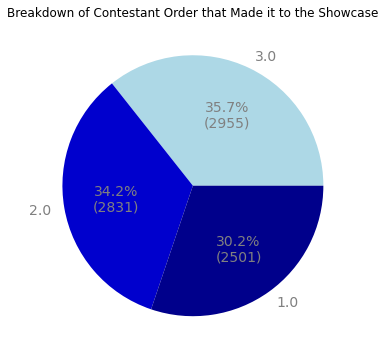

In [8]:
winner_order = sc_df.loc[sc_df.Winner].ContestantOrder.value_counts().reset_index()
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize =(10, 6))
plt.title("Breakdown of Contestant Order that Made it to the Showcase")
wedges, texts, autotexts = plt.pie(winner_order.ContestantOrder, labels=winner_order['index'],
                                   colors=['lightblue', 'mediumblue', 'darkblue'],
                                   autopct = lambda pct: func(pct, winner_order.ContestantOrder),
                                  textprops = dict(color ="gray", size='14'))


In [ ]:
sc_df.Spin1 == 100

### Dollar Spins
The highest value with out going over is $1 or 100 on the wheel, can be obtained either in one spin or the combined value of two spins. Not including SpinOff dollar spins for now

In [24]:
print("Contestants: {0:,.0f}".format(len(sc_df)))
print("% Contestants spinning $1: {0:.1%}".format(sum(sc_df.Total == 100) / len(sc_df)))

Contestants: 24,864
% Contestants spinning $1: 8.0%


### Spin Total
After all 3 contestants spin, what is the Total that advances either to the Showcase Showdown or a tie spin-off

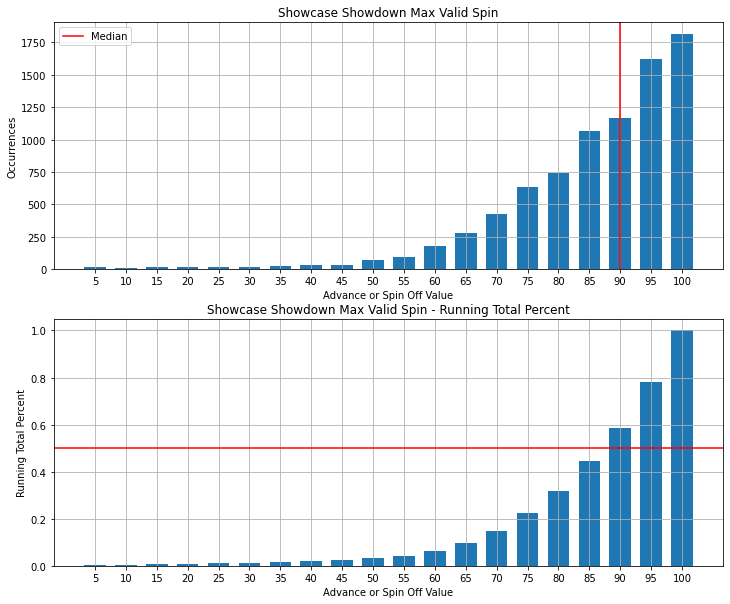

In [49]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.title("Showcase Showdown Max Valid Spin")
plt.hist(sc1r_df.EndValMax, bins=range(5, 110, 5), align='left', rwidth=0.7)
plt.axvline(sc1r_df.EndValMax.quantile(0.5), label='Median', color='red')
plt.legend()
plt.xlabel("Advance or Spin Off Value")
plt.ylabel("Occurrences")
plt.xticks(range(5, 105, 5))
plt.grid()
plt.subplot(2, 1, 2)
plt.title("Showcase Showdown Max Valid Spin - Running Total Percent")
plt.hist(sc1r_df.EndValMax, bins=range(5, 110, 5), align='left', rwidth=0.7, cumulative=True, density=True)
plt.xlabel("Advance or Spin Off Value")
plt.ylabel("Running Total Percent")
plt.axhline(0.5, color='red')
plt.xticks(range(5, 105, 5))
plt.grid()

plt.show()

### Contestant 1 - When to Spin Again

In [9]:
sc_df['SpunTwice'] = (sc_df.Spin2 > 0)
sc_df.SpunTwice.value_counts(normalize=True)

True     0.678008
False    0.321992
Name: SpunTwice, dtype: float64

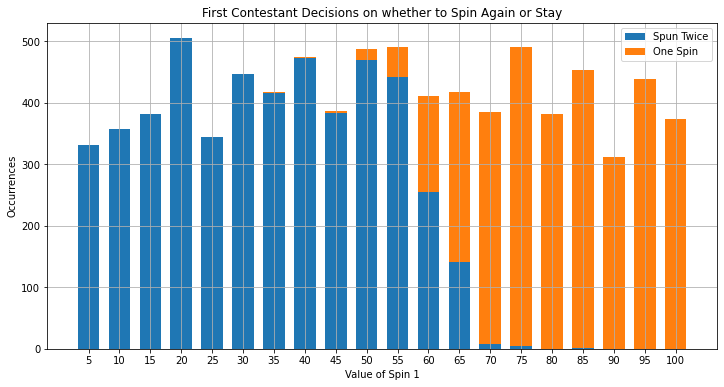

In [35]:
c1 = sc_df.loc[sc_df.ContestantOrder < 2, :].copy()
plt.figure(figsize=(12, 6))
plt.title("First Contestant Decisions on whether to Spin Again or Stay")
plt.hist([c1.loc[c1.SpunTwice].Spin1, c1.loc[~c1.SpunTwice].Spin1], bins=range(5, 110, 5),
         label=['Spun Twice', 'One Spin'], stacked=True, align='left', rwidth=0.7)
plt.legend()
plt.xlabel("Value of Spin 1")
plt.ylabel("Occurrences")
plt.xticks(range(5, 105, 5))
plt.grid()
plt.show()

The Median value of Contestants that advanced was 90.  Here we see at 70 the contestants stay. Probably about 15% of those who advanced or made it to a spinoff had a score of 70 or less

### Same for Contestant Two and Three

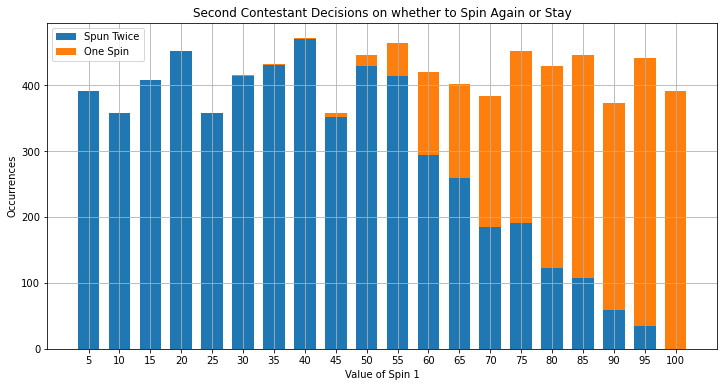

In [37]:
c2 = sc_df.loc[sc_df.ContestantOrder == 2, :].copy()
plt.figure(figsize=(12, 6))
plt.title("Second Contestant Decisions on whether to Spin Again or Stay")
plt.hist([c2.loc[c2.SpunTwice].Spin1, c2.loc[~c2.SpunTwice].Spin1], bins=range(5, 110, 5),
         label=['Spun Twice', 'One Spin'], stacked=True, align='left', rwidth=0.7)
plt.legend()
plt.xlabel("Value of Spin 1")
plt.ylabel("Occurrences")
plt.xticks(range(5, 105, 5))
plt.grid()
plt.show()

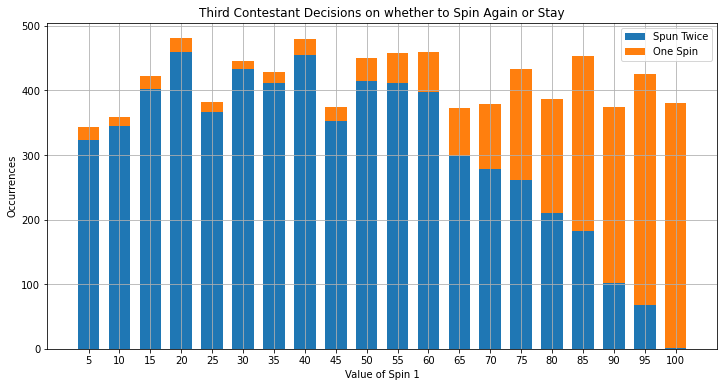

In [41]:
c3 = sc_df.loc[sc_df.ContestantOrder > 2, :].copy()
plt.figure(figsize=(12, 6))
plt.title("Third Contestant Decisions on whether to Spin Again or Stay")
plt.hist([c3.loc[c3.SpunTwice].Spin1, c3.loc[~c3.SpunTwice].Spin1], bins=range(5, 110, 5),
         label=['Spun Twice', 'One Spin'], stacked=True, align='left', rwidth=0.7)
plt.legend()
plt.xlabel("Value of Spin 1")
plt.ylabel("Occurrences")
plt.xticks(range(5, 105, 5))
plt.grid()
plt.show()

### SpinOff Rates

In [15]:
df.SpinOff1.isna().value_counts(normalize=True)

True     0.925385
False    0.074615
Name: SpinOff1, dtype: float64

In [48]:
sc_df.columns

Index(['url', 'episodeID', 'errorCode', 'footer', 'urlParam', 'EpsCategory',
       'airDate', 'SC_ind', 'PrizeValue', 'Contestant', 'Spin1', 'Spin2',
       'Total', 'Comments', 'Showcase', 'ev1', 'ev2', 'ev3', 'ev4',
       'ContestantOrder', 'CommNums', 'Total_test', 'EndVal', 'EndValMax',
       'EndValMatch', 'EndValMatchCnt', 'SpinOff1', 'SpinOff1Max',
       'SpinOff1Match', 'SpinOff1MatchCnt', 'SpinOff2', 'SpinOff2Max',
       'SpinOff2Match', 'SpinOff2MatchCnt', 'SpinOff3', 'SpinOff3Max',
       'SpinOff3Match', 'SpinOff3MatchCnt', 'Bonus', 'Winner'],
      dtype='object')